In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

import warnings
warnings.filterwarnings('ignore')

In [2]:
AAPL = pd.read_csv("../../Stock-Price-Prediction/data/dataset/APPL.csv")
AAPL["Date"] = pd.to_datetime(AAPL["Date"])
AAPL.set_index("Date", inplace=True)

In [3]:
AAPL

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,37.845036,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.075386,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.530045,234428400
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.450966,219111200
2019-01-08,37.389999,37.955002,37.130001,37.687500,36.126766,164101200
...,...,...,...,...,...,...
2024-04-08,169.029999,169.199997,168.240005,168.449997,168.449997,37425500
2024-04-09,168.699997,170.080002,168.350006,169.669998,169.669998,42451200
2024-04-10,168.800003,169.089996,167.110001,167.779999,167.779999,49709300


Mô hình LSTM này được thiết kế để dự đoán giá đóng cửa của cổ phiếu sử dụng 7 ngày trước đó làm bộ nhớ. Dữ liệu được chia thành tập huấn luyện và tập kiểm tra. Tập huấn luyện được sử dụng để huấn luyện mạng LSTM, trong đó mỗi mẫu dữ liệu có 7 bước thời gian và 1 đầu ra. Mạng LSTM có 4 lớp LSTM, mỗi lớp được kết nối với một lớp Dropout để tránh overfitting. Sau khi huấn luyện, mô hình được sử dụng để dự đoán giá đóng cửa của cổ phiếu trên tập kiểm tra.
- Dữ liệu được chuẩn hóa bằng MinMaxScaler để đảm bảo rằng các giá trị đều trong phạm vi từ 0 đến 1 trước khi đưa vào mô hình.
- Mạng LSTM được cấu hình với 4 lớp LSTM, mỗi lớp có 50 đơn vị neuron.
- Lớp cuối cùng là một lớp kết nối đầy đủ với 1 đơn vị, đại diện cho giá đóng cửa dự đoán.
- Mô hình được huấn luyện bằng adam optimizer và hàm mất mát mean squared error (MSE).
- Kết quả dự đoán được trực quan hóa bằng đồ thị, và sai số RMSE cũng được tính toán để đánh giá hiệu suất của mô hình.
Về phần sau của hàm, sau khi đã huấn luyện mô hình, nó sẽ sử dụng mô hình đã huấn luyện để dự đoán giá đóng cửa của cổ phiếu trong tập kiểm tra và tính toán sai số RMSE. Cuối cùng, nó sử dụng mô hình để dự đoán giá đóng cửa của cổ phiếu vào ngày tiếp theo và trả về giá dự đoán cùng với RMSE của dự đoán.

In [4]:
def LSTM_ALGO(df):
    """
    Perform stock price prediction using LSTM (Long Short-Term Memory) model.

    Args:
    - df (pd.DataFrame): DataFrame containing stock data.

    Returns:
    - tuple: A tuple containing the LSTM prediction and its corresponding RMSE.
    """
    # Split data into training set and test set
    dataset_train = df.iloc[0:int(0.8 * len(df)), :]
    dataset_test = df.iloc[int(0.8 * len(df)):, :]

    # Extracting the 'Close' price column for training
    training_set = df.iloc[:, 4:5].values

    # Feature Scaling
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range=(0, 1))
    training_set_scaled = sc.fit_transform(training_set)

    # Creating data structure with 7 timesteps and 1 output
    X_train = []
    y_train = []
    for i in range(7, len(training_set_scaled)):
        X_train.append(training_set_scaled[i - 7:i, 0])
        y_train.append(training_set_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping: Adding 3rd dimension
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    regressor = Sequential()

    # Add LSTM layers
    #Adding the first LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(0.2))
    # Adding a second LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.2))
    # Adding a third LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units=50, return_sequences=True))
    regressor.add(Dropout(0.2))
    # Adding a fourth LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units=50))
    regressor.add(Dropout(0.2))

    # regressor.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
    # #units=no. of neurons in layer
    # #input_shape=(timesteps,no. of cols/features)
    # #return_seq=True for sending recc memory. For last layer, retrun_seq=False since end of the line
    # regressor.add(Dropout(0.1))
    
    # #Add 2nd LSTM layer
    # regressor.add(LSTM(units=50,return_sequences=True))
    # regressor.add(Dropout(0.1))
    
    # #Add 3rd LSTM layer
    # regressor.add(LSTM(units=50,return_sequences=True))
    # regressor.add(Dropout(0.1))
    
    # #Add 4th LSTM layer
    # regressor.add(LSTM(units=50))
    # regressor.add(Dropout(0.1))
    
    # Add output layer
    regressor.add(Dense(units=1))

    # Compile
    regressor.compile(optimizer='adam', loss='mean_squared_error')

    # Training
    regressor.fit(X_train, y_train, epochs=100, batch_size=32)
    # regressor.fit(X_train,y_train,epochs=25,batch_size=32 )
    
    # Testing
    real_stock_price = dataset_test.iloc[:, 4:5].values

    # Combine train and test set to get the entire dataset
    dataset_total = pd.concat((dataset_train['Close'], dataset_test['Close']), axis=0)
    testing_set = dataset_total[len(dataset_total) - len(dataset_test) - 7:].values
    testing_set = testing_set.reshape(-1, 1)

    # Feature scaling
    testing_set = sc.transform(testing_set)

    # Create data structure
    X_test = []
    for i in range(7, len(testing_set)):
        X_test.append(testing_set[i - 7:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Testing Prediction
    predicted_stock_price = regressor.predict(X_test)

    # Getting original prices back from scaled values
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(real_stock_price, color='blue', label='Actual Price')
    plt.plot(predicted_stock_price, color='red', label='Predicted Price')
    plt.title('Stock Price Prediction using LSTM')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    # Print RMSE, MAE, MSE, MAPE
    error_lstm = np.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))

    print()
    print("------")

    # Print the prediction for the last day in the dataset
    last_date = dataset_total.index[-1]  # Get the last date in the entire dataset
    print(f"Closing Price Prediction by LSTM ({last_date}):", predicted_stock_price[-1])

    # Print RMSE, MAE, MSE, MAPE
    print("LSTM RMSE: ", error_lstm)
    print("------")

    return predicted_stock_price, error_lstm

Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.2041
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0128
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0058
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0054
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0047
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0048
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0044
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0041
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0043
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0039
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0036
Epoch 12/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0037
Epoch 13/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0046
Epoch 14/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0037
Epoch 15/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - l

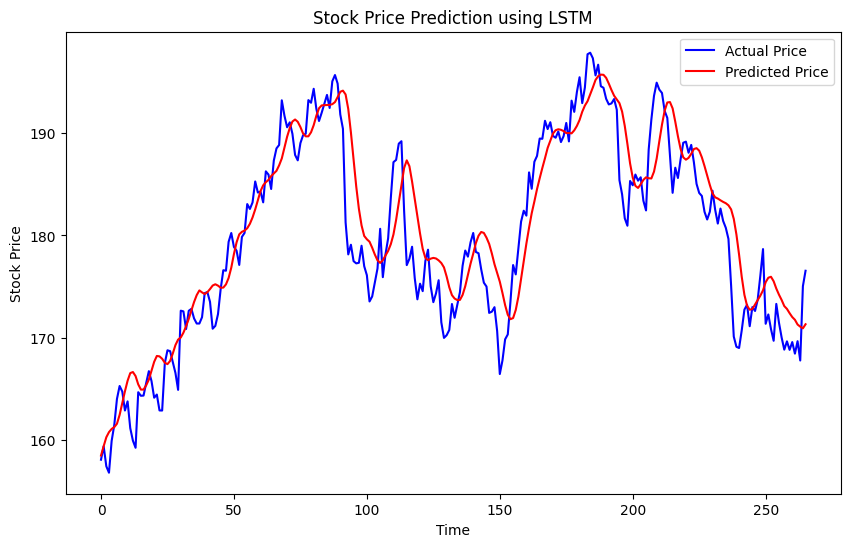


------
Closing Price Prediction by LSTM (2024-04-12 00:00:00): [171.32181]
LSTM RMSE:  3.9789810036197095
------


(array([[158.4934 ],
        [159.40788],
        [160.27983],
        [160.77974],
        [161.09074],
        [161.27002],
        [161.60278],
        [162.46288],
        [163.60619],
        [164.7706 ],
        [165.8016 ],
        [166.54904],
        [166.65271],
        [166.25975],
        [165.4505 ],
        [164.93877],
        [164.93889],
        [165.3601 ],
        [165.9182 ],
        [166.79393],
        [167.65459],
        [168.22353],
        [168.18457],
        [167.94771],
        [167.55876],
        [167.42421],
        [167.73706],
        [168.46353],
        [169.28864],
        [169.82364],
        [170.02765],
        [170.4993 ],
        [171.1267 ],
        [171.84738],
        [172.65216],
        [173.49197],
        [174.17087],
        [174.62927],
        [174.43394],
        [174.27444],
        [174.45651],
        [174.7605 ],
        [175.10535],
        [175.23184],
        [175.09653],
        [174.89178],
        [174.90244],
        [175.

In [5]:
LSTM_ALGO(AAPL)